# FPENet
Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [6]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [7]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [9]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [10]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [11]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10)
                    ],p=1)

In [12]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [13]:
transforms2=Compose([],p=1)

In [14]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [15]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [16]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [17]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [18]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [19]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

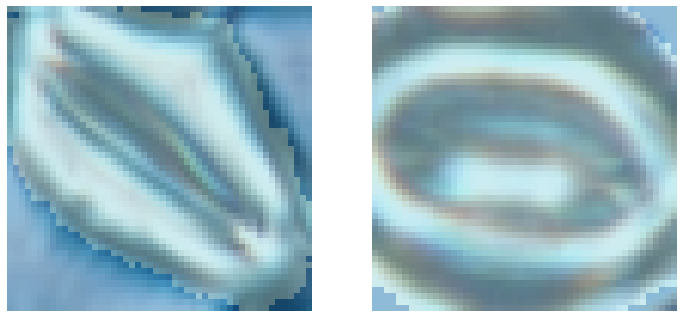

In [20]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [21]:
from architectures import FPENet
model = FPENet(nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [22]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/FPENet"

Freeze y elección de la tasa de aprendizaje.

Recorder

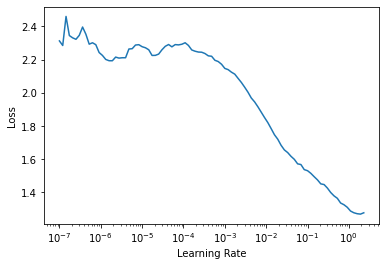

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.861960,0.870769,0.801811,0.669186,08:26
1,0.505295,0.482805,0.881666,0.788375,08:29
2,0.397160,0.385269,0.905685,0.827628,08:31
3,0.359243,0.353558,0.909245,0.833592,08:29
4,0.333187,0.334444,0.909613,0.834211,08:38
5,0.328447,0.321362,0.914116,0.841818,08:27
6,0.330306,0.311101,0.918745,0.849703,08:21
7,0.328215,0.311390,0.918167,0.848715,08:18
8,0.327379,0.307316,0.917343,0.847307,08:17
9,0.315747,0.301498,0.919968,0.851796,08:24


Better model found at epoch 0 with valid_loss value: 0.8707690834999084.


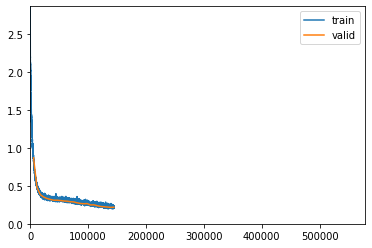

Better model found at epoch 1 with valid_loss value: 0.48280471563339233.
Better model found at epoch 2 with valid_loss value: 0.38526904582977295.
Better model found at epoch 3 with valid_loss value: 0.3535580635070801.
Better model found at epoch 4 with valid_loss value: 0.3344436287879944.
Better model found at epoch 5 with valid_loss value: 0.3213622570037842.
Better model found at epoch 6 with valid_loss value: 0.311101496219635.
Better model found at epoch 8 with valid_loss value: 0.30731624364852905.
Better model found at epoch 9 with valid_loss value: 0.30149808526039124.
Better model found at epoch 10 with valid_loss value: 0.29870420694351196.
Better model found at epoch 11 with valid_loss value: 0.29147660732269287.
Better model found at epoch 12 with valid_loss value: 0.28835320472717285.
Better model found at epoch 13 with valid_loss value: 0.27730414271354675.
Better model found at epoch 14 with valid_loss value: 0.26864057779312134.
Better model found at epoch 15 with va

In [ ]:
name = "model_FPENet_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_da_wd2")
learn.validate()

Unfreeze y elección de la tasa de aprendizaje.

Recorder

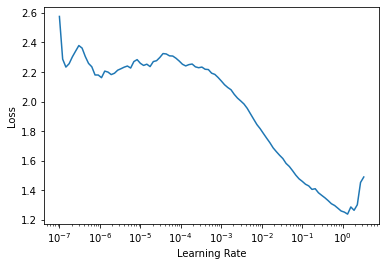

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.793376,0.891529,0.774533,0.632031,08:56
1,0.438981,0.430318,0.887920,0.798432,08:58
2,0.371437,0.364241,0.908460,0.832275,09:01
3,0.375398,0.338361,0.914371,0.842250,09:00
4,0.336412,0.324694,0.916042,0.845089,08:56
5,0.312934,0.316943,0.917989,0.848410,09:00
6,0.321826,0.311150,0.917246,0.847142,09:02
7,0.316933,0.304010,0.920148,0.852105,09:00
8,0.305654,0.300548,0.921160,0.853843,09:02
9,0.300764,0.297546,0.920285,0.852340,09:00


Better model found at epoch 0 with valid_loss value: 0.8915287852287292.


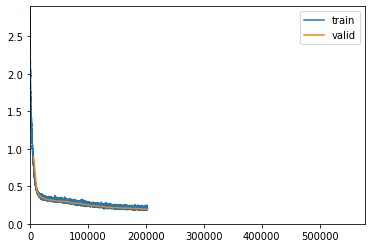

Better model found at epoch 1 with valid_loss value: 0.4303175210952759.
Better model found at epoch 2 with valid_loss value: 0.36424142122268677.
Better model found at epoch 3 with valid_loss value: 0.33836081624031067.
Better model found at epoch 4 with valid_loss value: 0.32469362020492554.
Better model found at epoch 5 with valid_loss value: 0.31694281101226807.
Better model found at epoch 6 with valid_loss value: 0.3111495077610016.
Better model found at epoch 7 with valid_loss value: 0.3040100038051605.
Better model found at epoch 8 with valid_loss value: 0.3005480170249939.
Better model found at epoch 9 with valid_loss value: 0.29754623770713806.
Better model found at epoch 10 with valid_loss value: 0.29722651839256287.
Better model found at epoch 11 with valid_loss value: 0.2839784622192383.
Better model found at epoch 12 with valid_loss value: 0.27761584520339966.
Better model found at epoch 13 with valid_loss value: 0.2738416790962219.
Better model found at epoch 14 with vali

In [ ]:
name = "model_FPENet_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.19686801731586456,0.9487716639558035,0.9025362344455625]



---


Definición del modelo.

In [ ]:
del model, learn
model = FPENet(nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/FPENet"

Freeze y elección de la tasa de aprendizaje.

Recorder

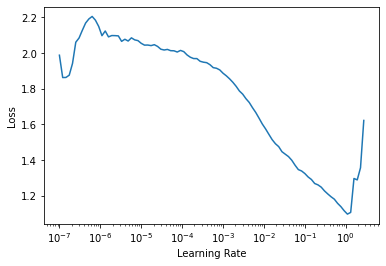

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.681763,0.679974,0.818825,0.693229,08:29
1,0.461986,0.420021,0.897093,0.813390,08:26
2,0.385815,0.365344,0.909182,0.833486,08:23
3,0.341197,0.348186,0.914703,0.842813,08:24
4,0.344624,0.319732,0.916958,0.846650,08:23
5,0.323106,0.313193,0.917985,0.848403,08:22
6,0.329583,0.304242,0.921102,0.853743,08:22
7,0.321881,0.298581,0.921441,0.854325,08:21
8,0.329724,0.298046,0.921264,0.854022,08:21
9,0.308350,0.296882,0.923430,0.857753,08:20


Better model found at epoch 0 with valid_loss value: 0.6799739599227905.


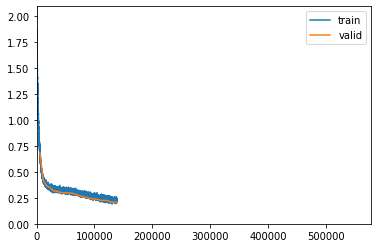

Better model found at epoch 1 with valid_loss value: 0.4200211465358734.
Better model found at epoch 2 with valid_loss value: 0.36534425616264343.
Better model found at epoch 3 with valid_loss value: 0.34818601608276367.
Better model found at epoch 4 with valid_loss value: 0.31973204016685486.
Better model found at epoch 5 with valid_loss value: 0.3131929636001587.
Better model found at epoch 6 with valid_loss value: 0.3042423725128174.
Better model found at epoch 7 with valid_loss value: 0.2985808849334717.
Better model found at epoch 8 with valid_loss value: 0.29804614186286926.
Better model found at epoch 9 with valid_loss value: 0.296881765127182.
Better model found at epoch 10 with valid_loss value: 0.29104170203208923.
Better model found at epoch 11 with valid_loss value: 0.2792759835720062.
Better model found at epoch 12 with valid_loss value: 0.2691984176635742.
Better model found at epoch 13 with valid_loss value: 0.2589748799800873.
Better model found at epoch 14 with valid_l

In [ ]:
name = "model_FPENet_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.20663052797317505,0.9474499792368574,0.900147223929478]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Recorder

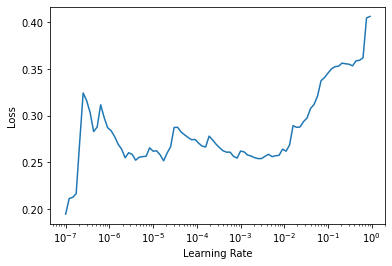

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.226927,0.204954,0.947182,0.899663,08:49
1,0.222968,0.205694,0.946759,0.898900,08:50
2,0.216869,0.206480,0.946372,0.898202,08:50


Better model found at epoch 0 with valid_loss value: 0.20495381951332092.


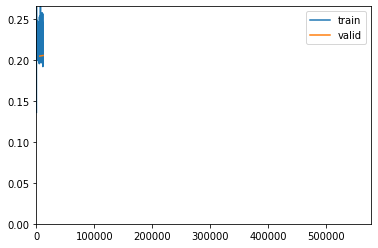

No improvement since epoch 0: early stopping


In [ ]:
name = "model_FPENet_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.20495381951332092,0.9471818011371819,0.8996632107616136]

# Modelos sin aumento de datos
Definición del modelo.

In [ ]:
del model, learn
model = FPENet(nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/FPENet"

Freeze y elección de la tasa de aprendizaje.

Recorder

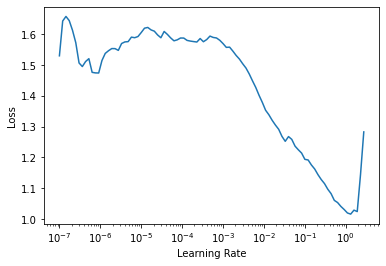

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.710832,0.723008,0.801939,0.669364,08:34
1,0.434571,0.419960,0.893280,0.807141,08:35
2,0.382344,0.368983,0.911407,0.837233,08:36
3,0.356692,0.336275,0.914261,0.842064,08:36
4,0.377386,0.321243,0.918115,0.848626,08:37
5,0.360800,0.310714,0.919151,0.850396,08:36
6,0.335247,0.305359,0.920254,0.852288,08:36
7,0.318925,0.304569,0.922003,0.855292,08:38
8,0.319691,0.291352,0.923922,0.858601,08:36
9,0.301336,0.284898,0.924772,0.860070,08:35


Better model found at epoch 0 with valid_loss value: 0.7230076193809509.


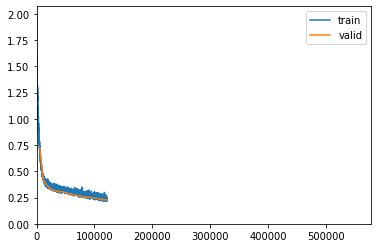

Better model found at epoch 1 with valid_loss value: 0.41995978355407715.
Better model found at epoch 2 with valid_loss value: 0.3689833879470825.
Better model found at epoch 3 with valid_loss value: 0.3362748622894287.
Better model found at epoch 4 with valid_loss value: 0.32124316692352295.
Better model found at epoch 5 with valid_loss value: 0.31071367859840393.
Better model found at epoch 6 with valid_loss value: 0.3053591549396515.
Better model found at epoch 7 with valid_loss value: 0.3045693039894104.
Better model found at epoch 8 with valid_loss value: 0.2913520038127899.
Better model found at epoch 9 with valid_loss value: 0.2848982810974121.
Better model found at epoch 10 with valid_loss value: 0.27596473693847656.
Better model found at epoch 11 with valid_loss value: 0.27177685499191284.
Better model found at epoch 12 with valid_loss value: 0.26181653141975403.
Better model found at epoch 13 with valid_loss value: 0.2588645815849304.
Better model found at epoch 14 with valid

In [ ]:
name = "model_FPENet_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.22886359691619873,0.9405249805612279,0.8877273775265087]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

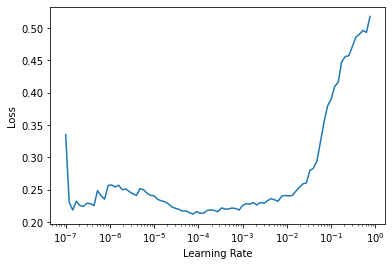

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.241511,0.224337,0.942912,0.891990,08:33
1,0.242025,0.221941,0.943063,0.892260,08:23
2,0.227704,0.224592,0.941723,0.889864,08:23
3,0.271721,0.222786,0.942441,0.891147,08:22


Better model found at epoch 0 with valid_loss value: 0.22433684766292572.


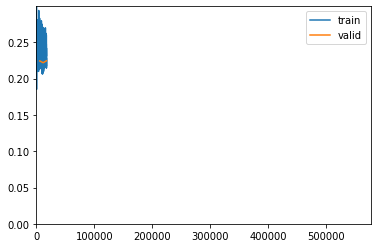

Better model found at epoch 1 with valid_loss value: 0.22194087505340576.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_FPENet_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.22194087505340576,0.943062824961169,0.8922600578662792]



---


Definición del modelo.

In [ ]:
del model, learn
model = FPENet(nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/FPENet"

Freeze y elección de la tasa de aprendizaje.

Recorder

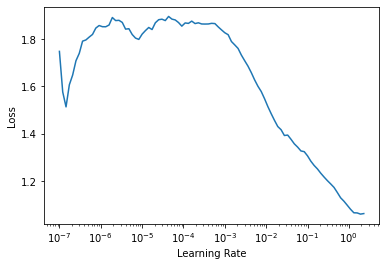

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.665060,0.767932,0.791084,0.654374,08:22
1,0.427538,0.419506,0.891231,0.803803,08:22
2,0.372373,0.359630,0.908282,0.831974,08:20
3,0.354083,0.326088,0.915072,0.843440,08:22
4,0.344588,0.323543,0.916693,0.846198,08:21
5,0.329951,0.310815,0.918545,0.849360,08:23
6,0.328733,0.304481,0.919469,0.850941,08:24
7,0.303740,0.298166,0.921979,0.855252,08:19
8,0.323979,0.292684,0.923534,0.857932,08:20
9,0.307719,0.283899,0.925012,0.860485,08:22


Better model found at epoch 0 with valid_loss value: 0.767932116985321.


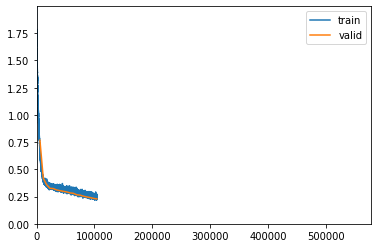

Better model found at epoch 1 with valid_loss value: 0.4195059835910797.
Better model found at epoch 2 with valid_loss value: 0.3596297800540924.
Better model found at epoch 3 with valid_loss value: 0.3260883092880249.
Better model found at epoch 4 with valid_loss value: 0.3235431909561157.
Better model found at epoch 5 with valid_loss value: 0.31081461906433105.
Better model found at epoch 6 with valid_loss value: 0.30448058247566223.
Better model found at epoch 7 with valid_loss value: 0.2981664538383484.
Better model found at epoch 8 with valid_loss value: 0.292683869600296.
Better model found at epoch 9 with valid_loss value: 0.2838985323905945.
Better model found at epoch 10 with valid_loss value: 0.28008797764778137.
Better model found at epoch 11 with valid_loss value: 0.2665063142776489.
Better model found at epoch 12 with valid_loss value: 0.2631274163722992.
Better model found at epoch 13 with valid_loss value: 0.2536507844924927.
Better model found at epoch 14 with valid_los

In [ ]:
name = "model_FPENet_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.2287178784608841,0.9406377548091699,0.8879283352596037]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Recorder

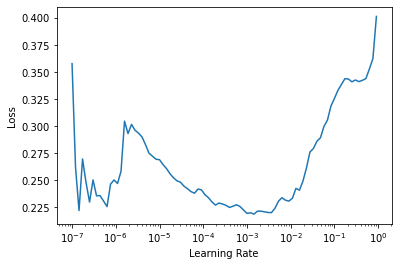

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.226911,0.226205,0.941950,0.890269,08:34
1,0.241248,0.224480,0.942668,0.891553,08:35
2,0.236302,0.229461,0.940436,0.887569,08:35
3,0.237172,0.223731,0.942867,0.891909,08:29
4,0.236311,0.222921,0.942518,0.891285,08:29
5,0.238133,0.224856,0.942337,0.890961,08:22
6,0.244002,0.221297,0.942919,0.892002,08:22
7,0.269303,0.221227,0.942467,0.891195,08:23
8,0.222585,0.216879,0.944303,0.894484,08:22
9,0.225848,0.218353,0.943691,0.893385,08:20


Better model found at epoch 0 with valid_loss value: 0.22620545327663422.


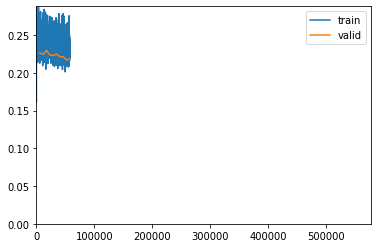

Better model found at epoch 1 with valid_loss value: 0.2244795560836792.
Better model found at epoch 3 with valid_loss value: 0.2237313985824585.
Better model found at epoch 4 with valid_loss value: 0.22292108833789825.
Better model found at epoch 6 with valid_loss value: 0.22129718959331512.
Better model found at epoch 8 with valid_loss value: 0.21687909960746765.
No improvement since epoch 8: early stopping


In [ ]:
name = "model_FPENet_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_FPENet_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.21687909960746765,0.9443034887887798,0.8944838585337019]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_FPENet_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.19606947898864746,0.950023120208641,0.9048038471070146]

Comparación de resultado buscado contra resultado obtenido.

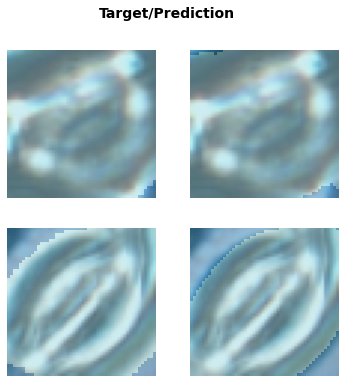

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_FPENet_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1747586578130722,0.9554205318162633,0.9146460953109691]

Comparación de resultado buscado contra resultado obtenido.

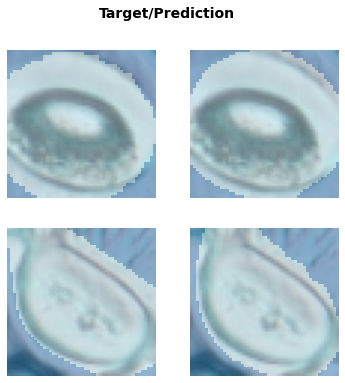

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_FPENet_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.19068393111228943,0.9521060380233874,0.9085900602265681]

Comparación de resultado buscado contra resultado obtenido.

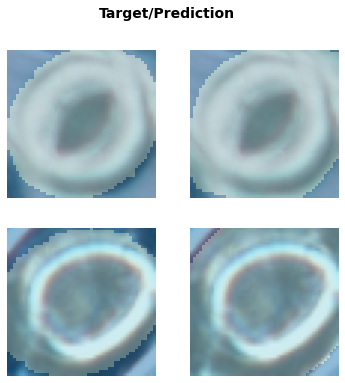

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_FPENet_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1846991330385208,0.9535674998952353,0.9112556230810567]

Comparación de resultado buscado contra resultado obtenido.

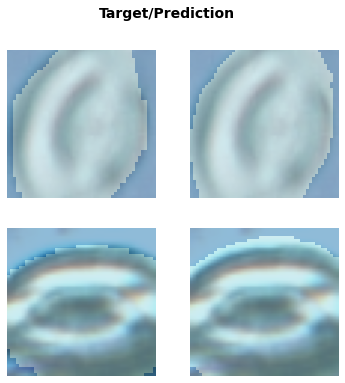

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_FPENet_wd2")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.20506414771080017,0.948061546332875,0.9012519154783928]

Comparación de resultado buscado contra resultado obtenido.

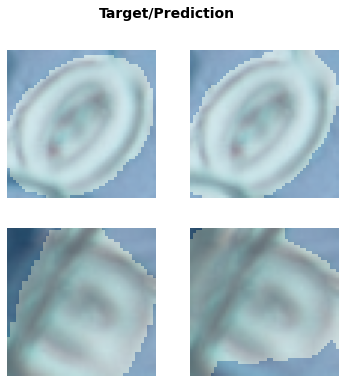

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_FPENet_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.20035980641841888,0.9491694311566048,0.9032563947976079]

Comparación de resultado buscado contra resultado obtenido.

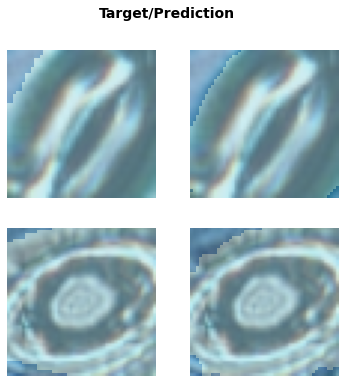

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_FPENet_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.20552848279476166,0.9472398750080306,0.8997680027207113]

Comparación de resultado buscado contra resultado obtenido.

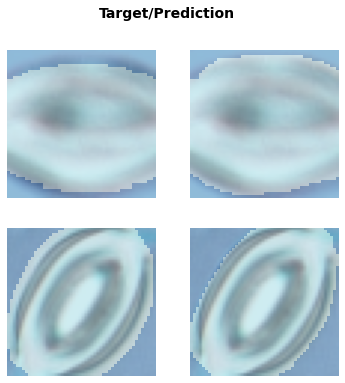

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_FPENet_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.19636473059654236,0.9500524082494199,0.9048569811616933]

Comparación de resultado buscado contra resultado obtenido.

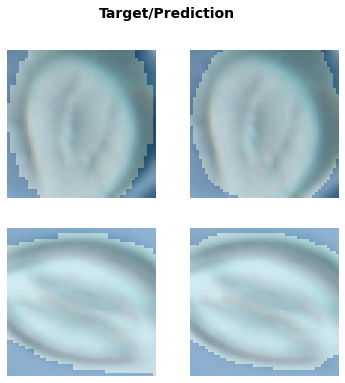

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [23]:
learn.load("model_FPENet_da_wd2_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17475837469100952,0.9554205318162633,0.9146460953109691]

In [24]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [25]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/FPENet/model_FPENet.pkl")